# I. Implementación K-means
K-means
    Elegir instacias del dataset como centroides iniciales
    Distirbuir puntos del dataset a los centroides
    Calcular la media de las distancias respecto de los puntos
    Se recalculaba el centroide 
    Repetir hasta que no haya cambios
    
Estaría bien usar la misma interfaz que sckikit learn
Kmeans = Kmeans(K=5)
Kmeans.fit(X)
Kmeans.predict(X)

Tenemos un conjunto de datos, eliges el numero de clusters (n_clusters), asignas los centroides a unos datos aleatoriamente (init -> puntos aleatorios del dataset), y después asignas los datos a los clusters (asignar_clusters). Después hay que computar los nuevos centroides en un bucle y volver a asignar los clusters hasta que se cumpla la condición de parada.

In [1]:
# con la librería de SciKit Learn:
import sklearn
from sklearn.cluster import KMeans

kmeans = KMeans()
#kmeans.fit(X)
#kmeans.predict(X)

In [2]:
import numpy as np
import math
from math import dist
import statistics as s
import matplotlib
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
import random

In [3]:
x, y = make_blobs()
print(x.shape[1])
print("EQUIS: \n", x)
print("Y: \n", y)

2
EQUIS: 
 [[  7.98435254   2.4122428 ]
 [  2.78394811  -7.76123609]
 [  8.77851337   0.13941834]
 [  7.06882438   3.54216687]
 [  8.85277142  -0.73434618]
 [  9.45368239  -2.61319717]
 [  9.35835491   5.09469349]
 [  2.34598358  -8.17787769]
 [  7.13837218   4.06168354]
 [  1.8770893   -8.26013096]
 [  6.89914653  -0.8897067 ]
 [  9.53791589  -2.94125649]
 [  1.52311654  -7.71195777]
 [  7.60282438   1.37570319]
 [  8.56686823  -0.8054581 ]
 [  7.74538945   2.79904521]
 [  7.54132176   3.02361748]
 [  1.23814137  -8.94725195]
 [  7.33459259   3.99839232]
 [  1.87811471  -7.37104688]
 [  3.72023177  -7.14538729]
 [  7.32718816  -0.1414089 ]
 [  8.05243093   3.6946092 ]
 [  9.72711526  -1.40431931]
 [  2.29949874  -8.45164462]
 [  9.17628318   4.28429299]
 [  2.80724439  -9.85188226]
 [  8.6280698    0.47830319]
 [  8.41223528  -0.86102518]
 [  8.64371025   4.91209165]
 [  2.08647952  -7.59928377]
 [  8.31530192  -1.9186017 ]
 [  6.18026893   3.11569428]
 [  8.39463524  -0.76041186]
 [ 

In [4]:
len(x)

100

In [5]:
class KMeans_Ours():
    def __init__(self, n_clusters=8, max_iter=100, random_state=55):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.iter = 0
        self.random_state = random_state
        
        self.X= []
        
        self._centroids= []
        self._inertia=[]
        self._labels=[]
        self.history = {'iteration': [],
                        'centroids':  [],  
                        'labels' : [],
                        'inertia':  []
                        }
    
    def fit(self, X):
        """Este método entrena el modelo con el dataset proporcionado, aplicando el algoritmo de asignación de centroides"""
        self.X = X
        self._assign_centroids()
        self._assign_labels()
        # print("centroides iniciales: ", self._centroids)
        while not self._stop(): # si se llega a max iter o si centroides no cambian (con último valor de self.history), una u otra
            self._add_history_step() 
            # con esto podemos hacer un gráfico (no se pide pero quedaría rechulón)
            
            self._update_centroides()
            # print("history: ", self.history['centroids'][self.iter])
            self._assign_labels()
            
            self.iter += 1
            
    def return_centroids(self):
        return self._centroids
    
    def return_labels(self):
        return self._labels
    
    def predict(self, X):
        # contemplar posibilidad de triangulación
        predictions = []
        for row in X:
            min_distance = math.inf
            nearest_centroid = None
            for centroid_label in range(self.n_clusters):
                distance = dist(row, self._centroids[centroid_label])
                # print("distancia entre", row, "y", self._centroids[centroid_label], "es: ", distance, "con label", centroid_label)
                # print("distancia: ", distance, "\nmin_distancia: ", min_distance)
                if distance < min_distance:
                    # print("dentro if")
                    min_distance = distance
                    nearest_centroid = centroid_label
            predictions.append(nearest_centroid)
        return predictions
    
    def _assign_centroids(self):
        # utilizar el módulo random de numpy para asignar los centroides: check
        # sólo para la primera iteración (asignación de centroides iniciales): check
        # un centroide a la misma posición dato aleatoriamente 
        # con replace = false nos aseguramos de que no se repita el mismo valor para dos centroides diferentes,
        # de forma que todos los centroides tomen coordenadas distintas
        c_index = np.random.choice(list(range(0, len(self.X))), size = self.n_clusters, replace = False)
        # print(c_index)
        for i in c_index:
            self._centroids.append(self.X[i])
            # print("centroide ",i, ": ", self.X[i])
        # print(self._centroids)
        # asignar valores de los datos a los que equivalen esas posiciones en la tabla a los "centroides"        
    
    def _assign_labels(self):
        # función para asignar los datos a un centroides
        # linalg.norm -> normaliza los vectores, no calcula distancias como tal; no es lo que buscamos
        self._inertia = []
        self._labels = []
        
        # generación de la matriz
        for i in range(len(self.X)):
            self._inertia.append(self._compute_inertia(self.X[i]))
            
            # encasillamiento con labels de cada dato a su respectivo centroide 
            self._labels.append(np.argmin(self._inertia[i], axis = 0))
        
        
    def _stop(self):
        """ condición de parada del bucle de actualización de labels y centroides de función fit()
        si devuelve False, no se cumple la condición de parada. 
        si devuelve True sí se cumple la condición de parada: se para la ejecución"""
        # print("stop")
        
        # condición de parada por iteraciones, asegurando que la primera ejecución siempre ocurre 
        # (en history no hay nada, para que no compare y de error)
        if self.iter == self.max_iter: 
            return True
        if self.iter == 0:
            return False
        
        prev_centroids= self.history['centroids'][-1]
        cambia = [False] * self.n_clusters
        # print(self.history)
        # print("centroides previos: ", prev_centroids)
        # print("centroides actualizados: ", self._centroids)
        for i in range (self.n_clusters):
            #Si este centroide no cambia respecto del mismo en la anterior iteración, devolver True para este centroide
            if np.array_equal(self._centroids[i], prev_centroids[i]):
                # print("no ha cambiado el centroide ", i)
                cambia[i] = True
        #Si no hay diferencias, los centroides no han cambiado en la última iteración y se cumple la condición de parada.    
        # Es decir, si todos son iguales
        if False in cambia:
            return False
        return True
    
    def _update_centroides(self):
        # siguientes iteraciones para reposicionar los centroides
    
        for i in range(self.n_clusters):
            control= []
            for j in range(len(self.X)):
                if self._labels[j]==i:
                        control.append(self.X[j])
            #print("control list:", control)
            #print(np.mean(control))
            self._centroids[i]= np.mean(control, axis = 0)
        # print("centroides actualizados", self._centroids)
    
    def _compute_inertia(self, x):
        """ distancia entre el dato o row 'x' y cada centroide' """
        distance_row=[]
        
        for centroid in self._centroids: 
            #print(x, centroid)
            distance_row.append(dist(x,centroid))
       
        return distance_row
        
    def _add_history_step(self):
        """ actualización de historial de centroides para nueva iteración """
        # self.history es un array de diccionarios, cada uno con toda esta información
        self.history['iteration'].append(self.iter)
        self.history['centroids'].append(self._centroids.copy())
        self.history['labels'].append(self._labels.copy())
        self.history['inertia'].append(self._inertia.copy())
        
        # print("history: ", self.history['centroids'][self.iter])
        # print("centroides: ", self._centroids)
        
    def scatterplot_centroids(self):
        """creates a scatterplot with the final centroids
        only valid for self.X with 2 dimensions"""
        for i in range(self.n_clusters):
             plt.scatter(self._centroids[i][0], self._centroids[i][1])
    
    """
    def scatterplot_all(self):
        # actualmente este código funciona pero da muchísimos errores: revisar si se quiere incluir o se hará a mano
        # creación de n colores aleatorios por n_clusters
        
        colors = []
        for i in range(self.n_clusters):
            r = random.randint(0, 255) / 255.0
            g = random.randint(0, 255) / 255.0
            b = random.randint(0, 255) / 255.0
            colors.append((r, g, b))

        # Crear una lista de colores para cada punto en los datos
            for j in range(len(self.X)):
                if self._labels[j] == i:
                    plt.scatter(self.X[j][0], self.X[j][1], c=colors[i])
    """


In [6]:
kmeans = KMeans_Ours(n_clusters=3)
result = kmeans.fit(x)
kmeans.return_centroids()

[array([ 2.81394904, -9.04879582]),
 array([ 8.33838241, -0.87673907]),
 array([8.19533472, 3.45583758])]

In [7]:
print("centroides finales: ", kmeans.return_centroids())
print("número de iteraciones totales: ", kmeans.iter)

centroides finales:  [array([ 2.81394904, -9.04879582]), array([ 8.33838241, -0.87673907]), array([8.19533472, 3.45583758])]
número de iteraciones totales:  4


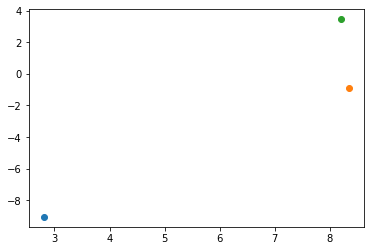

In [8]:
"""for i in range(3):
     plt.scatter(cent[i][0], cent[i][1])"""
kmeans.scatterplot_centroids()

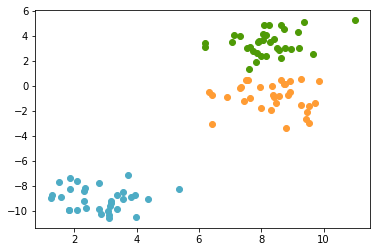

In [9]:
# kmeans.scatterplot_all()
colors = ["#4EACC5", "#FF9C34", "#4E9A06"]
for i in range(kmeans.n_clusters):
    for j in range(len(x)):
        if kmeans._labels[j] == i:
            plt.scatter(x[j][0], x[j][1], c=colors[i])

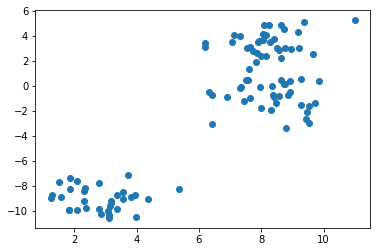

In [10]:
plt.scatter(x[:, 0], x[:, 1])

In [11]:
dist(kmeans.predict(x), kmeans.return_labels())
#print(len(kmeans.return_labels()), len(kmeans.predict(x)))

0.0

# con estrellas


In [12]:
import pandas as pd
stars = pd.read_csv('Stars2.csv')

In [13]:
print(stars.shape)
len(stars)

(240, 6)


240

In [14]:
stars.head()

,Temperature,L,R,A_M,Color,Spectral_Class
0,3068,0.002400,0.1700,16.12,Red,M
1,3042,0.000500,0.1542,16.60,Red,M
2,2600,0.000300,0.1020,18.70,Red,M
3,2800,0.000200,0.1600,16.65,Red,M
4,1939,0.000138,0.1030,20.06,Red,M


prueba: para ello necesitamos eliminar el color y la spectral class (sólo en este caso), en realidad: hacer Onehotencoding etc.

In [15]:
stars_prueba = stars.drop(columns = ["Color", "Spectral_Class"])
#stars.drop["Spectral_Class"]
stars_prueba

,Temperature,L,R,A_M
0,3068,0.002400,0.1700,16.12
1,3042,0.000500,0.1542,16.60
2,2600,0.000300,0.1020,18.70
3,2800,0.000200,0.1600,16.65
4,1939,0.000138,0.1030,20.06
...,...,...,...,...
235,38940,374830.000000,1356.0000,-9.93
236,30839,834042.000000,1194.0000,-10.63
237,8829,537493.000000,1423.0000,-10.73
238,9235,404940.000000,1112.0000,-11.23


In [16]:
# convert dataframe to array
stars_prueba_array = stars_prueba.values
stars_prueba_array

array([[ 3.06800e+03,  2.40000e-03,  1.70000e-01,  1.61200e+01],
       [ 3.04200e+03,  5.00000e-04,  1.54200e-01,  1.66000e+01],
       [ 2.60000e+03,  3.00000e-04,  1.02000e-01,  1.87000e+01],
       [ 2.80000e+03,  2.00000e-04,  1.60000e-01,  1.66500e+01],
       [ 1.93900e+03,  1.38000e-04,  1.03000e-01,  2.00600e+01],
       [ 2.84000e+03,  6.50000e-04,  1.10000e-01,  1.69800e+01],
       [ 2.63700e+03,  7.30000e-04,  1.27000e-01,  1.72200e+01],
       [ 2.60000e+03,  4.00000e-04,  9.60000e-02,  1.74000e+01],
       [ 2.65000e+03,  6.90000e-04,  1.10000e-01,  1.74500e+01],
       [ 2.70000e+03,  1.80000e-04,  1.30000e-01,  1.60500e+01],
       [ 3.60000e+03,  2.90000e-03,  5.10000e-01,  1.06900e+01],
       [ 3.12900e+03,  1.22000e-02,  3.76100e-01,  1.17900e+01],
       [ 3.13400e+03,  4.00000e-04,  1.96000e-01,  1.32100e+01],
       [ 3.62800e+03,  5.50000e-03,  3.93000e-01,  1.04800e+01],
       [ 2.65000e+03,  6.00000e-04,  1.40000e-01,  1.17820e+01],
       [ 3.34000e+03,  3.

In [17]:
kmeans_stars_prueba = KMeans_Ours()
result = kmeans_stars_prueba.fit(stars_prueba_array)
print(kmeans_stars_prueba.return_centroids())
print(kmeans_stars_prueba.iter)

C:\Anaconda\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Anaconda\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


TypeError: 'numpy.float64' object is not iterable

In [ ]:
plt.scatter(stars_prueba_array[:, 0], stars_prueba_array[:, 1], stars_prueba_array[:, 2], stars_prueba_array[:, 3])

In [ ]:
colors = ["#FF9C34", "#4E9A06", "#DEB887", "#65B199", "#BDD4EE", "#3F567A", "#526AD5", "#00D542"]
for i in range(kmeans_stars_prueba.n_clusters):
    for j in range(len(stars_prueba_array)):
        if kmeans_stars_prueba._labels[j] == i:
            # aquí hay que hacer lo de reducir a sólo dos dimensiones para poder hacer el scatterplot 
            # (sólo deja con dos dimensiones)
            plt.scatter(stars_prueba_array[j][0], stars_prueba_array[j][1], c = colors[i])

# II. Preprocesado de Datos
En esta sección se preprocesa el dataset proporcionado, aplicando procesamiento de features de tipo One-hot-encoding y codificación ordinal, así como transformación de la dimensionalidad de los datos mediante PCA. 

In [ ]:
import pandas as pd
stars = pd.read_csv('Stars2.csv')
stars.head()

En primer lugar, observamos los diferentes colores asociados a las estrellas

In [ ]:
stars['Color'].unique()

Podemos ver que algunos valores se repiten con ligeras diferencias en el nombre de la etiqueta. Por ejemplo, "yellowish" y "Yellowish" son la misma etiqueta pero con la primera letra escrita en minúscula y mayúscula respectivamente. Por lo tanto, modificamos los nombres de las etiquetas de color a minúsculas

In [ ]:
stars['Color'] = stars['Color'].str.lower()
stars['Color'].unique()

También observamos que "blue-white" es la misma etiqueta que "blue white", con la diferencia del guión que separa las dos palabras, que en el primer caso está presente y en el segundo no. Algo similar ocurre con "yellow-white" y "white-yellow". Asumimos en estos dos casos que el valor del atributo es el mismo, y para ello modificamos el nombre de las etiquetas para que ninguna tenga guión y proponemos el orden "yellow white" para todos los casos. Asumimos también que hay una diferencia entre "yellowish white" y "yellow white", igual que hay diferencia entre "white" y "whitish", por lo que estos dos valores del atributo "Color" se mantienen como diferentes valores.

In [ ]:
stars.loc[stars['Color']=='blue-white', 'Color'] = 'blue white'
stars.loc[stars['Color']=='white-yellow', 'Color'] = 'yellow white'
stars.loc[stars['Color']=='yellow-white', 'Color'] = 'yellow white'

In [ ]:
stars['Color'].unique()

In [ ]:
stars[stars['Color']=='blue white']

A continuación, se preprocesan los valores del atributo 'Spectral_Class' para asegurar que todos ellos son correctos, mediante un proceso similar al realizado para el atirbuto 'Color'.

In [ ]:
stars['Spectral_Class'].unique()

Es fácilmente observable que todos los valores son correctos, se corresponden con la escala de valores proporcionada en el enunciado de esta práctica, y no se repiten ni presentan errores de nombramiento de las etiquetas, por lo que no es necesario realizar modificaciones en este atributo del dataframe.

Una vez se han preprocesado los atributos de la clase espectral y el color asociados a cada estrella de nuestro dataframe, se llevan a cabo dos técnicas para transformar los datos y poder trabajar con variables categóricas. 

En primer lugar, se llevará a cabo la técnica de "One-Hot-Encoding" de cada una de estas dos variables. A continuación, se llevará a cabo una transformación de las variables a atributos ordinales, de forma que se ordenan los colores según se atribuyan a mayor o menor temperatura, e igualmente para la variable de la clase espectral.

Para poder comparar los resultados arrojados por una técnica y otra, generamos dos copias de nuestro dataframe según el tratamiento de los datos

In [ ]:
stars_1hot= stars.copy()
stars_ordinal= stars.copy()

## 1. One Hot Encoding
Se estudia la posibilidad de convertir las variables categóricas del dataset a vairables numéricas binarias mediante la técnica del One-Hot-Encoding, que genera una variable binaria para cada posible valor del atributo original.

In [ ]:
#1. One Hot Encoding de color

for color in stars_1hot['Color'].unique():
    labels= []
    #Iteramos 1 vez por fila
    for i in stars_1hot['Color']:
        if i==color:
            labels.append(1)
        else:
            labels.append(0)
    stars_1hot[color]= labels

# se elimina el atributo inicial
stars_1hot = stars_1hot.drop(columns=["Color"])

stars_1hot

In [ ]:
#2. One hot encoding de Clase espectral
for spectral in stars_1hot['Spectral_Class'].unique():
    labels= []
    #Iteramos 1 vez por fila
    for i in stars_1hot['Spectral_Class']:
        if i==spectral:
            labels.append(1)
        else:
            labels.append(0)
    stars_1hot[spectral]= labels

# se elimina el atributo inicial
stars_1hot = stars_1hot.drop(columns=["Spectral_Class"])
    
stars_1hot

## 2. Ordinal Scale Encoding
En esta segunda variante, convertimos las variables categóricas a escalas ordinales. 

In [ ]:
# orden de clase espectral asociada a una estrella de menor a mayor energía
spectral_class=["M","K","G","F","A","B","O"]

In [ ]:
labels= []

#Iteramos 1 vez por fila
for i in stars_ordinal['Spectral_Class']:
    labels.append(spectral_class.index(i))
       
stars_ordinal['Spectral_Class']= labels
    
stars_ordinal


En el caso de los colores, debemos averiguar en primer lugar el orden, es decir, qué colores se asignan a las estrellas menos calientes y cuáles a las más caliente. Para ello, se ha decidido ordenar los colores según la temperatura media de todas las estrellas asociadas a un mismo color. A continuación se obtiene dicho orden, de colores con menor temperatura media a aquellos con mayor temperatura media.

In [ ]:
color_means=[]

iter = 0
for color in stars_ordinal['Color'].unique():
    
    temp= stars_ordinal[stars_ordinal['Color']==color]['Temperature'].mean()
    
    # inserción del primer elemento
    if iter == 0:
        color_means.append({'Color': color, 'Temperature': temp})
    
    # inserción del resto, comprobando la posición de inserción
    else:
        inserted= False
        i=0
        while not inserted and i<len(color_means):
            if temp <= color_means[i]['Temperature']:
                color_means.insert(i, {'Color': color, 'Temperature': temp})
                inserted = True
            i+=1
        
        if not inserted:
            color_means.append({'Color': color, 'Temperature': temp})
            
    iter += 1 
    # print("array de medias actualizado: ", color_means)

colors = []
for i in range(len(color_means)):
    colors.append(color_means[i]['Color'])
print("Array of sorted colors", colors)


En base a ello se procede a asignar la etiqueta ordinal correspondiente al color de cada estrella.

In [ ]:
labels= []

#Iteramos 1 vez por fila
for i in stars_ordinal['Color']:
    labels.append(colors.index(i))

stars_ordinal['Color']= labels
    
stars_ordinal


## 3.PCA
Para poder aplicar el algoritmo de clasificación y poder representar los datos correctamente se aplica un algoritmo de PCA, Análisis de Componentes Principales. Esto es necesario para reducir la dimensionalidad y permitir la correcta visualización de los datos clusterizados, ya que actualmente están formados por más de dos dimensiones (las dimensiones son los atributos).


In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

En primer lugar se debe llevar a cabo un nuevo preprocesamiento de los datos para escalar las variables.

In [ ]:
#features = stars_1hot.columns.tolist()
#features_ = stars_1hot[[features[0], features[1], features[2]]]

# con el dataset preprocesado con ordinal scaler
scaler = StandardScaler()
stars_ordinal_scaled= scaler.fit_transform(stars_ordinal[['Temperature', 'L', 'R', 'A_M', 'Color', 'Spectral_Class']])
stars_ordinal_scaled

In [ ]:
# con el dataset preprocesado con One Hot Encoding
stars_1hot_scaled = scaler.fit_transform(stars_1hot[['Temperature', 'L', 'R', 'A_M', 'red', 'blue white', 'white',
                                                    'yellowish white', 'pale yellow orange', 'blue', 'whitish', 
                                                    'yellow white', 'orange', 'yellowish', 'orange-red', 'M', 'B', 
                                                    'A', 'F', 'O', 'K', 'G']])
stars_1hot_scaled

In [ ]:
pca = PCA(n_components=2)
stars_ordinal_pca = pca.fit_transform(stars_ordinal_scaled)
stars_ordinal_pca

In [ ]:
stars_1hot_pca = pca.fit_transform(stars_1hot_scaled)
stars_1hot_pca

# III. Aplicación de Algoritmos de clustering 

In [ ]:
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN


## 1. K-means
### A. Selección de número de clusters - Método del Codo
En primer lugar, es necesario escoger un número de clusters adecuado para especificar el hiperparámetro del modelo K-means. Para ello se emplea el método "del codo", que compara la inercia obtenida para un rango de posibles valores de n_clusters.

In [ ]:
def elbow_method(data, init= 2, final= 8):
    """Calcula los coeficientes del método del codo para el rango de enteros init-final"""
    results= [] 
    for i in range(init, final+1): 
        kmeans = KMeans(n_clusters=i)  #Cada iteración se crea un número distinto de clústers.
        kmeans.fit(data)
        results.append(kmeans.inertia_)
    #Impresión del gráfico
    plt.plot(range(init, final +1 ), results)


In [ ]:
elbow_method(stars_1hot_pca)

In [ ]:
elbow_method(stars_ordinal_pca)

### Intepretación de resultados
Tras aplicar la función a ambos sets de datos, e pueden obsrvar ligeras difrencias en la gráfica obtenida. 
Para los datos tratados con one-hot-encoding, se observa una primera "punta" del codo para 3 clusters. A partir de aquí, comienza un descenso considerable de la variación marginal de la inercia, suavizando la curva para los valores más altos. 
Por otra parte, el codo obtenido para los datos ordinales presenta una curva menos marcada, con un extremo de codo entorno a los 4 o 5 clústers. 
Con esto en cuenta, se realizará una clusterización con 4 clústers para cada método, a fin de respetar los resultados obtenidos y facilitar la comparación entre ambos conjuntos de datos. También se realiza una segunda clasificación con 6 clústers en base a las categorías proporcionadas en el enunciado. Esta segunda ejecución permitirá evaluar los conjuntos obtenidos en el último apartado de la práctica. 

### B. Aplicación de k-means

In [ ]:

def kmeans_clustering(data, n):
    kmeans = KMeans(n_clusters=n)  # Número de clusters a crear
    kmeans.fit(data)
    results = {'labels': kmeans.labels_,
              'centroids': kmeans.cluster_centers_}
    return results

# Resultados para 4 clústers
km1hot_n4 = kmeans_clustering(stars_1hot_pca, 4)
print("K-Means (One-Hot Encoding) with 4 clusters:",np.bincount(km1hot_n4['labels']), 
      "\nCentroides: ", km1hot_n4['centroids'])

kmord_n4 = kmeans_clustering(stars_ordinal_pca, 4)
print("\nK-Means (Ordinal) with 4 clusters:", np.bincount(kmord_n4['labels']), 
      "\nCentroides: ", kmord_n4['centroids'])

# Resultados para 6 clústers
km1hot_n6 = kmeans_clustering(stars_1hot_pca, 6)
print("\nK-Means (One-Hot Encoding) with 6 clusters:", np.bincount(km1hot_n6['labels']), 
      "\nCentroides: ", km1hot_n6['centroids'])

kmord_n6 = kmeans_clustering(stars_ordinal_pca, 6)
print("\nK-Means (Ordinal) with 6 clusters:", np.bincount(kmord_n6['labels']), 
      "\nCentroides: ", kmord_n6['centroids'])



Creación de una función para imprimir el scatterplot de los resultados de los algoritmos de clustering.

In [ ]:
def clustering_plot(n_clusters, data, colors, results):
    for i in range(n_clusters):
        for j in range(len(data)):
            if results['labels'][j] == i:
                plt.scatter(data[j][0], data[j][1], c=colors[i])
    for centroid in results['centroids']:
        plt.scatter(centroid[0], centroid[1], marker='*', s=100, c='black')


In [ ]:
colors = ["#4EACC5", "#FF9C34", "#4E9A06","#8E44AD", "#FF6347", "#FFC0CB" ]
n_clusters_4 = 4
n_clusters_6 = 6

In [ ]:
#1-hot n4 clustering plot
clustering_plot(n_clusters_4, stars_1hot_pca, colors, km1hot_n4)

In [ ]:
#Ordinal n4 clustering plot
clustering_plot(n_clusters_4, stars_ordinal_pca, colors, kmord_n4)

In [ ]:
#1-hot n6 clustering plot
clustering_plot(n_clusters_6, stars_1hot_pca, colors, km1hot_n6)

In [ ]:
#Ordinal n6 clustering plot
clustering_plot(n_clusters_6, stars_ordinal_pca, colors, kmord_n6)

### Discusión de resultados


## 2. Clustering Jerárquico
En este segundo método se emplea la técnica de clustering jerárquico para realizar la agrupación de los datos. 

In [ ]:
# Algoritmo de Clustering Jerárquico
def hierarchical_clustering(data, n= None, dist=0):
    hierarchical = AgglomerativeClustering(distance_threshold=dist, n_clusters=n)  # Número de clusters a crear
    return hierarchical.fit(data)
def hierarchical_labels(data, n=None, dist=0):    
    hierarchical = AgglomerativeClustering(distance_threshold=dist, n_clusters=n)  # Número de clusters a crear
    return hierarchical.fit(data).labels_


model_hier_c1Hot= hierarchical_clustering(stars_1hot_pca)
model_hier_ord=  hierarchical_clustering(stars_ordinal_pca)

#print("Clustering Jerárquico (One-Hot Encoding) with 4 clusters:", np.bincount(labels_hier_c1Hot))
#print("Clustering Jerárquico (Ordinal Encoding) with 4 clusters:", np.bincount(labels_hier_ord))


Una vez entrenado un modelo general y definidas las funciones para obtener el modelo y las etiquetas generadas, se imprime un gráfico mostrando la jerarquía creada por el algoritmo. 

In [ ]:
#Generación de dendograma -implementación por sklearn.
from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [ ]:
plot_dendrogram(model_hier_c1Hot, truncate_mode="level", p=3)

In [ ]:
plot_dendrogram(model_hier_ord, truncate_mode="level", p=3)

Como se puede observar, y en concordancia con los resultados obtenidos para el algoritmo k-means, ejecutar el algoritmo con un número de clusters superior a 3 afina notablemente los resultados, proporcionando una clasificación mucho más precisa. 
A efectos de comparación con el método anterior se realizan las llamadas al método para 4 y 6 clusters.

In [ ]:
def clustering_hier_plot(n_clusters, data, colors, results):
    for i in range(n_clusters):
        for j in range(len(data)):
            if results[j] == i:
                plt.scatter(data[j][0], data[j][1], c=colors[i])

In [ ]:
labels_hier_1Hot_n4 = hierarchical_labels(stars_1hot_pca, n_clusters_4, None)

#1hot n4 clustering plot
clustering_hier_plot(n_clusters_4, stars_1hot_pca, colors, labels_hier_1Hot_n4)

In [ ]:
labels_hier_ord_n4= hierarchical_labels(stars_ordinal_pca, n_clusters_4, None)

#Ordinal n4 clustering plot
clustering_hier_plot(n_clusters_4, stars_ordinal_pca, colors, labels_hier_ord_n4)

In [ ]:
labels_hier_1Hot_n6= hierarchical_labels(stars_1hot_pca, 6, None)

#1hot n6 clustering plot
clustering_hier_plot(n_clusters_6, stars_1hot_pca, colors, labels_hier_1Hot_n6)

In [ ]:
labels_hier_ord_n6= hierarchical_labels(stars_ordinal_pca, 6, None)

#Ordinal n6 clustering plot
clustering_hier_plot(n_clusters_6, stars_ordinal_pca, colors, labels_hier_ord_n6)

### Discusión de resultados

## 3. DBA -Clustering por densidades
Finalmente, se implementa un último método de clustering basado en densidades. 

In [ ]:
# Algoritmo de DBSCAN
def dbscan_clustering(data):
    dbscan = DBSCAN(eps=0.5, min_samples=5)  # Parámetros eps y min_samples
    labels = dbscan.fit_predict(data)
    return labels


# Comparar y discutir los resultados
# Por ejemplo, podríamos imprimir los conteos de cada etiqueta de clustering para cada algoritmo
#labels_dbscan_1hot = dbscan_clustering(stars_1hot)
#labels_dbscan_ordinal = dbscan_clustering(stars_ordinal)

#print("DBSCAN (One-Hot Encoding):", np.bincount(labels_dbscan_1hot))

#print("DBSCAN (Ordinal Encoding):", np.bincount(labels_dbscan_ordinal))

In [ ]:
# print(labels_kmeans_ordinal)

In [ ]:
colors = ["#4EACC5", "#FF9C34", "#4E9A06"]
for i in range(kmeans.n_clusters):
    for j in range(len(stars_1hot_pca)):
        if labels_kmeans_1hot[j] == i:
            plt.scatter(stars_1hot_pca[j][0], stars_1hot_pca[j][1], c=colors[i])

In [ ]:
colors = ["#4EACC5", "#FF9C34", "#4E9A06"]
for i in range(kmeans.n_clusters):
    for j in range(len(stars_ordinal_pca)):
        if labels_kmeans_1hot[j] == i:
            plt.scatter(stars_ordinal_pca[j][0], stars_ordinal_pca[j][1], c=colors[i])

La distribución de los datos es diferente porque el preprocesado también ha sido diferente, se ha llevado a cabo el algoritmo de PCA sobre datos tratados de manera distinta, y por lo tanto, sobre más dimensiones iniciales en el caso de los datos preprocesados con One Hot Encoding.

In [ ]:
kmeans_ours = KMeans_Ours(n_clusters = 3)
kmeans_ours.fit(stars_1hot_pca)
kmeans_ours_1hot_labels = kmeans_ours.return_labels()
colors = ["#4EACC5", "#FF9C34", "#4E9A06"]
for i in range(kmeans_ours.n_clusters):
    for j in range(len(stars_1hot_pca)):
        if kmeans_ours_1hot_labels[j] == i:
            plt.scatter(stars_1hot_pca[j][0], stars_1hot_pca[j][1], c=colors[i])

In [ ]:
kmeans_ours = KMeans_Ours(n_clusters = 3)
kmeans_ours.fit(stars_ordinal_pca)
kmeans_ours_ordinal_labels = kmeans_ours.return_labels()
colors = ["#4EACC5", "#FF9C34", "#4E9A06"]
for i in range(kmeans_ours.n_clusters):
    for j in range(len(stars_ordinal_pca)):
        if kmeans_ours_ordinal_labels[j] == i:
            plt.scatter(stars_ordinal_pca[j][0], stars_ordinal_pca[j][1], c=colors[i])

Se puede observar que la clasificación es idéntica, en los resultados los grupos son los mismos.

### PRUEBAS

In [ ]:
import statistics as s
hola = [1, 2, 3]
s.mean(hola)
array1 = np.array([1, 2, 3])
array2 = np.array([4, 5, 6])
todos = []
todos.append(array1)
todos.append(array2)
print(todos)
# Calcular la media de los dos arrays
media_arrays = np.mean(todos, axis = 0)
media_arrays

In [ ]:
colors = ["#4EACC5", "#FF9C34", "#4E9A06"]
for i in range(kmeans.n_clusters):
    for j in range(len(x)):
        if kmeans._labels[j] == i:
            plt.scatter(x[j][0], x[j][1], c=colors[i])



In [ ]:
print(hola)
print(hola[-1])

In [ ]:
print(np.random.choice(list(range(0, len(stars))), size = 5, replace = False))

In [ ]:
X = np.random.random(size = (100, 2))
centroide = np.random.random_integers(0, len(X))
centroide
len(X)

In [ ]:
centroids = []
centroids = np.random.choice(range(0, len(X)), size = 8, replace = False)
centroids

In [ ]:
matriz = [1, 2, [3, 4], [5, 6]]
print(matriz[0][2], matriz[2][1])

In [ ]:
matriz_distancias = []
for i in range(len(X)):
    matriz_distancias.append([])
    for j in range(7):
         matriz_distancias[i].append(np.random.randint(1, 10))



In [ ]:
labels_=[]
for i in range(len(matriz_distancias)):
    labels_.append(np.argmin(matriz_distancias[i], axis = 0))

labels_

In [ ]:
np.random.randint(1, 10)

In [ ]:
np.argmin(matriz_distancias, axis=0)

In [ ]:
kmeans = KMeans()
kmeans.fit(X)

Scikit learn es una librería de código abierto, se puede ver cómo está implementado en Scikit learn, no copiar la misma solución, pero usarlo como inspiración. Hay un apartado de indicar similitud con scikit learn.

## PCA
Algoritmo no supervisado muy útil, reduce la dimensionalidad de los datos (columnas). En lugar de eliminar columnas, existen métodos más interesantes que ese.
Prdecir el número escrito en el gráfico en base a la luminosidad de los píxeles. Se ve bien con cmap = 'Greys'.

Se usará el algoritmo PCA antes del algoritmo de clustering, y el de clustering se usará sobre las dos dimensiones que devuelve PCA (kmeans o lo que sea)

In [ ]:
from sklearn.datasets import load_digits
import matplotlib.pylot as plt

from sklearn.decomposition import PCA

X = load.digits().data
X.shape
plt.imshow(np.reshape(X[0], (8,8)))
pca = PCA.fit(X)
plt.plot

In [ ]:
X_pca

# Pruebas fallidas...

In [ ]:
"""self.history.centroids
        
        for i in range(self.n_clusters):
            centroide = np.random.random_integers(0, len(self.X)-1, size=self.n_clusters)
            
            for c in centroide:
                if centroide.count(c) == 1:
                    self.history.centroids.append(X[c])
                else:
                    centroide[c] = np.random.random_integers(0, len(self.X)-1)
                    while centroide
            
            duplicate = False
            while self.history.centroids du
            if i>0:
                for i in range(len(self.history.centroids)):
                    if centroide == self.history.centroids[i]:
                        
            self.history.centroids.append(np.)"""